In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import scipy.io
import tensorflow as tf

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import math
import pandas as pd

In [3]:
def bingham(y):
    #shear stress: t
    #shear rate:y
    y_f = 12.1
    A_0 = 43.6    
    A_1 =131.2    
    C = 56.1
    lam=0
    t = y_f+(A_0+(A_1-A_0)*lam)*(np.arcsinh(y/C))
    return t

class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

Compiling model...
Building feed-forward neural network...
'build' took 0.052607 s

'compile' took 0.181643 s

Initializing variables...


/Users/zhangtianjie/opt/anaconda3/envs/tf/lib/python3.7/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
2022-10-09 13:06:57.170310: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 13:06:57.303767: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss    Test loss     Test metric   
0         [5.58e+03]    [4.91e+03]    [1.00e+00]    


2022-10-09 13:06:57.336179: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1750] (One-time warning): Not using XLA:CPU for cluster.

If you want XLA:CPU, do one of the following:

 - set the TF_XLA_FLAGS to include "--tf_xla_cpu_global_jit", or
 - set cpu_global_jit to true on this session's OptimizerOptions, or
 - use experimental_jit_scope, or
 - use tf.function(jit_compile=True).

To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a
proper command-line flag, not via TF_XLA_FLAGS).


1000      [1.01e+03]    [7.10e+02]    [3.81e-01]    
2000      [1.67e+02]    [8.31e+01]    [1.30e-01]    
3000      [2.02e+01]    [5.79e+00]    [3.44e-02]    
4000      [1.75e+00]    [2.47e-01]    [7.11e-03]    
5000      [3.63e-01]    [3.17e-01]    [8.05e-03]    
6000      [1.33e-02]    [5.65e-03]    [1.07e-03]    
7000      [2.70e-03]    [5.17e-03]    [1.03e-03]    
8000      [2.11e-03]    [4.69e-03]    [9.79e-04]    
9000      [8.99e-03]    [1.20e-02]    [1.57e-03]    
10000     [2.63e-03]    [5.55e-03]    [1.07e-03]    
11000     [8.32e-02]    [9.82e-02]    [4.48e-03]    
12000     [1.13e-02]    [1.49e-02]    [1.75e-03]    
13000     [3.81e-02]    [4.52e-02]    [3.04e-03]    
14000     [1.06e-02]    [1.42e-02]    [1.71e-03]    
15000     [1.14e-02]    [1.51e-02]    [1.76e-03]    
16000     [1.20e-02]    [1.35e-02]    [1.66e-03]    
17000     [2.02e-01]    [2.22e-01]    [6.74e-03]    
18000     [1.25e-02]    [1.59e-02]    [1.80e-03]    
19000     [4.39e-03]    [7.13e-03]    [1.21e-0

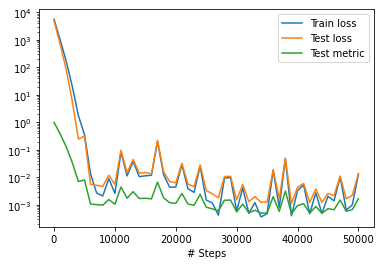

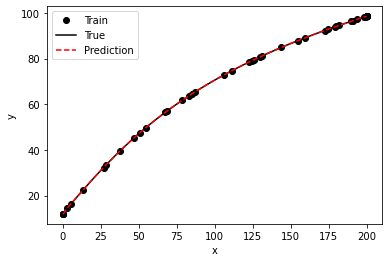

In [4]:
def PDE(x,y):
    #shear stress: t
    #shear rate:y
    y_f = 12.1
    A_0 = 43.6
    
    A_1 =131.2
    
    C = 56.1

    lam=0
    
    
    eq1 = y_f+(A_0+(A_1-A_0)*lam)*(tf.math.asinh(x/C))-y
    
#     eq2 = y_f+(A_0)*(tf.math.asinh(x/C))-y[:,1:2]

    
    
    return eq1

def func(x):
    
    return bingham(x)

geom = dde.geometry.TimeDomain(0, 200)
data = dde.data.TimePDE(geom, PDE, [], 35, 10,train_distribution='pseudo',solution=func, num_test=1000)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=50000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [5]:
train0=np.loadtxt('train.dat', unpack = True)
train = torch.from_numpy(train0)
test0=np.loadtxt('test.dat', unpack = True)
test = torch.from_numpy(test0)

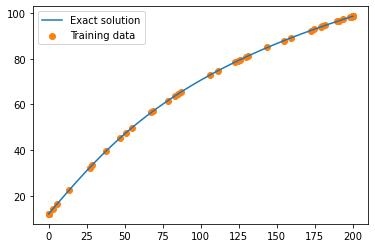

In [6]:
# get the analytical solution over the full domain
x = torch.linspace(0,200,2000).view(-1,1)
y = bingham(x).view(-1,1)
# # slice out a small number of points from the LHS of the domain
x_train = x[0:100:5]
# y_train = y[0:100:5]
#print(x_train)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(train[0].view(-1,1), train[1].view(-1,1), color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [7]:
torch.manual_seed(123)
model = FCN(1,1,50,5)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
files = []
losses = []
for i in range(50000):
    
    if i%10000==0:
        print('=====epochs=====',i)
    optimizer.zero_grad()
    yh = model(train[0].view(-1,1).float())
    loss = torch.mean((yh-train[1].view(-1,1).float())**2)# use mean squared error
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach().numpy())

=====epochs===== 0
=====epochs===== 10000
=====epochs===== 20000
=====epochs===== 30000
=====epochs===== 40000


In [8]:
x_test = test[0].view(-1,1).float()
y_test=model(x_test)

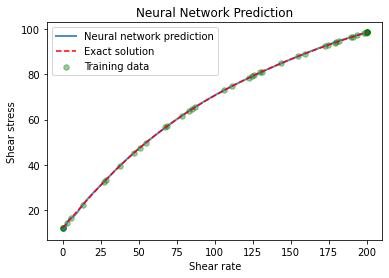

In [9]:
#plt.figure(figsize=(4,4))

plt.plot(x_test.detach().numpy(),y_test.detach().numpy(), color="tab:blue", linewidth=2, alpha=0.8, label="Neural network prediction")
plt.plot(x,y, '--r', label="Exact solution")
plt.scatter(train[0].detach().numpy(), train[1].detach().numpy(), s=30, color="green", alpha=0.4, label='Training data')
plt.legend()
# plt.ylim((0,1400))
plt.title('Neural Network Prediction')
plt.xlabel('Shear rate')
plt.ylabel('Shear stress')
# plt.yscale('log')
# plt.xscale('log')
nndata=pd.DataFrame(x_test.detach().numpy())
nndata[1]=pd.DataFrame(y_test.detach().numpy())
nndata.to_csv('nntest.csv')
plt.savefig('NN.png',dpi=600,bbox_inches = 'tight')

Text(0, 0.5, 'Loss')

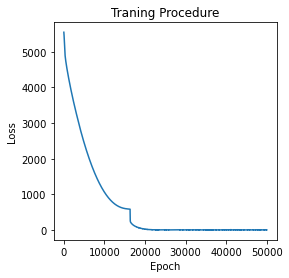

In [10]:
import pandas as pd
plt.figure(figsize=(4,4))
losses1=pd.DataFrame(losses)
losses1.to_csv('nnloss.csv')
#x= np.linspace(0, 13000, 15)
plt.plot(losses1)#,label='loss')
#plt.legend()

#plt.ylim(1e-9,1e6)
plt.title('Traning Procedure')
plt.xlabel('Epoch')
plt.ylabel('Loss')


In [11]:
LOSS=losses1.rename(columns={0:'nn'})

In [12]:
LOSS

,nn
0,5551.953613
1,5550.856445
2,5549.752441
3,5548.642578
4,5547.525879
...,...
49995,0.008982
49996,0.009320
49997,0.009363
49998,0.009029


In [13]:
# import pandas as pd
# test1=np.loadtxt('test.dat', unpack = True)
# f = pd.DataFrame(test1.T, columns = ['x','y','z'])
# f

In [14]:
# x = torch.linspace(0,200,20).view(-1,1)
# y = bingham(x).view(-1,1)

In [15]:
# plt.plot(f['x'],f['y'])

# plt.plot(x, y,'--r', label="Exact solution")



In [16]:
# train=np.loadtxt('train.dat', unpack = True)
# train1 = pd.DataFrame(train.T)
# train1

In [17]:
# plt.plot(f['x'],f['y'],c='black')

# # plt.plot(x, y,'--r', label="Exact solution")

# plt.scatter(xnn.detach().numpy(),y_test.detach().numpy(),marker='o', color="tab:blue", linewidth=0.2, alpha=0.8, label="Neural network prediction")
# plt.plot(x, y,'--r', label="Exact solution")
# #plt.scatter(train1[0],train1[1])

In [18]:
# loss=np.loadtxt('loss.dat', unpack = True)
# loss1 = pd.DataFrame(loss.T)
# loss1

# plt.plot(loss1[0],loss1[1],label='Train Loss')
# plt.plot(loss1[0],loss1[2],label='Test Loss')
# plt.plot(loss1[0],loss1[3],label='Test Metric')
# plt.yscale('log')
# plt.xlabel('Epochs')

# plt.legend()